# Milestone 1: Getting to know your data, due Wednesday, April 5, 2017

Lexi Attempt

## Description

In the beginning you should get acquainted with the data sources and do some EDA. Sign up for the TMDb [API](https://www.themoviedb.org/documentation/api), and try to download the poster of your favorite movie from within your notebook. Compare the genre entries of IMDb and TMDb for this movie and see if they are the same. Think about and write down some questions that you would like to answer in the following weeks. Keep the storytelling aspect of your final report in mind and do some pen and paper sketches about the visualizations you would like to produce. Include photographs of those sketches in your notebook. 


Most of the time a data scientist spends on a project is spend on cleaning the data. We are lucky that the data we have is already pretty clean. The Python interface to the IMDb ftp files does a lot of the additional work of cleaning as well. However, you will notice that the genre list for each movie from both databases can have different lengths. This needs to be changed in order to train a model to predict the movie genre. It is up to you to think about possible ways to address this problem and to implement one of them. There is no absolute right answer here. It depends on your interests and which questions you have in mind for the project. 

Optionally, you could also scrape additional data sources, such as Wikipedia, to obtain plot summaries. That data may give you additional useful features for genera classification. 

To guide your decision process, provide at least one visualization of how often genres are mentioned together in pairs. Your visualization should clearly show if a horror romance is more likely to occur in the data than a drama romance.

The notebook to submit for this milestone needs to at least include:

- API code to access the genre and movie poster path of your favorite movie (DONE!)
- Genre for this movie listed by TMDb and IMDb (DONE!)
- A list of the 10 most popular movies of 2016 from TMDb and their genre obtained via the API
- Comments on what challenges you see for predicting movie genre based on the data you have, and how to address them 
- Code to generate the movie genre pairs and a suitable visualization of the result
- Additional visualization sketches and EDA with a focus on movie genres
- A list of questions you could answer with this and related data. Get creative here!

The EDA questions do not necessarily have to tie into the modeling part later on. Think freely about things that might be interesting, like which actors are very specific to a genre? Are action movies more prone to producing sequels than romances? However, as you keep the focus on movie genres, think also about correlations you might discover that can help building features from the metadata for prediction. Is the length of a movie title correlated with genre?

### Downloading poster of my favorite movie

In [23]:
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns # Seaborn visualization package
import pandas as pd
import time
import re # Regex
import collections

# File reading things
import pickle
import json
import csv
import datetime # For handling dates

# The "requests" library makes working with HTTP requests easier
import requests
import os
from bs4 import BeautifulSoup
from IPython.display import Image, display # Display image from URL
from IPython.core.display import HTML # Display image from URL

# TMDB API wrapper
import tmdbsimple as tmdb

# IMDB access
import imdb

# Display options
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
%matplotlib inline

In [5]:
# os.getcwd()
os.chdir('/Users/AlexandraDing/Desktop')

### Viewing metadata and downloading poster using tmdbsimple API wrapper
# My API key (Lexi)
tmdb.API_KEY = 'ee0df3ce88063f7f6cd466ff61266a55'

# Access configuration to get base_url and file_size
config_url = "https://api.themoviedb.org/3/configuration"
payload = "{}"
response = requests.request("GET", config_url + '?api_key=' + tmdb.API_KEY, data=payload)
base_url =  response.json()['images']['base_url']
poster_sizes = response.json()['images']['poster_sizes']
print(base_url)
print(poster_sizes)

# Search for my favorite movie (Rogue One- Star Wars)
search = tmdb.Search()
response = search.movie(query = "Star Wars")
# Print search results
for s in search.results:
    print s['title'], s['id'], s['release_date']

favorite_movie = tmdb.Movies(330459)
favorite_response = favorite_movie.info()
print(favorite_response)

http://image.tmdb.org/t/p/
[u'w92', u'w154', u'w185', u'w342', u'w500', u'w780', u'original']
Star Wars 11 1977-05-25
Rogue One: A Star Wars Story 330459 2016-12-14
Star Wars: The Force Awakens 140607 2015-12-15
Star Wars: The Last Jedi 181808 2017-12-13
Star Wars: The Clone Wars 12180 2008-08-05
Star Wars: Episode I - The Phantom Menace 1893 1999-05-19
Star Wars: Episode II - Attack of the Clones 1894 2002-05-15
Star Wars: Episode III - Revenge of the Sith 1895 2005-05-17
The Star Wars Holiday Special 74849 1978-12-01
Star Wars: Episode IX 181812 2019-05-23
Star Wars: Clone Wars 420803 2003-11-07
Robot Chicken: Star Wars 42979 2007-07-17
Star Wars: Clone Wars: Volume 2 333365 2005-11-30
The Empire Strikes Back 1891 1980-05-17
Star Wars: Clone Wars: Volume 1 333355 2005-03-21
The Story of Star Wars 435365 2005-08-18
Star Wars: Greatest Moments 378386 2015-12-26
Han Solo: A Star Wars Story 348350 2018-05-24
Star Wars: Heroes & Villains 432134 2005-05-03
Star Wars: TIE Fighter 332479 201

In [14]:
# Request poster from URL: http://stackoverflow.com/questions/30229231/python-save-image-from-url
# (must specify base_url, file_size, poster_path, file_path)
poster_path = favorite_response['poster_path']
poster_size = 'w500'
poster_url = base_url + poster_size + poster_path

# Write poster jpg to cwd
img_data = requests.get(poster_url).content
with open('test_poster.jpg', 'wb') as handler:
    handler.write(img_data)
    
# Display image from URL in IPython Notebook
display(Image(url = poster_url))

### Compare Genre in IMDB and TMDB

Will use IMDBpy


In [18]:
# Create the object that will be used to access the IMDb's database.
ia = imdb.IMDb() # by default access the web.

# Search for a movie (get a list of Movie objects).
s_result = ia.search_movie('Star Wars')
# print(s_result)

rogue_one = ia.get_movie('3748528')
print rogue_one['director']
print rogue_one['genre']

# Compare to TMDb
print(favorite_response['genres'])

[<Person id:2284484[http] name:_Edwards, Gareth_>]
[u'Action', u'Adventure', u'Sci-Fi']
[{u'id': 28, u'name': u'Action'}, {u'id': 18, u'name': u'Drama'}, {u'id': 878, u'name': u'Science Fiction'}, {u'id': 10752, u'name': u'War'}]


**ADD SOME COMMENTS: GENRES ARE SLIGHTLY DIFFERENT**

### 10 most popular movies of 2016 and their Genres (TMDb)

Documentation: https://developers.themoviedb.org/3/discover

**PLAN TO TRY IT BOTH WITH REQUESTS AND THE WRAPPER PACKAGE**

In [25]:
# Uses JSON decoder in requests library
# Gets first page of results of sorted descending order popular movies of 2016
A= 'https://api.themoviedb.org/3/discover/movie?api_key=ee0df3ce88063f7f6cd466ff61266a55&language=en-US&sort_by=popularity.desc&include_adult=false&include_video=false&page=1&primary_release_year=2016'
response = requests.get(A)
response.text
top_movies = response.json()

top_movies_results = top_movies['results']
print 'Example of result', '\n', top_movies_results[0]

# Just want the top 10: Titles and Genre codes
### FIX THIS PART??!?!?!?!
top_movies_array = [[top_movies_results[i]['title'], top_movies_results[i]['genre_ids']] for i in range(10)]
top_movies_dict = [{top_movies_results[i]['title']: top_movies_results[i]['genre_ids']} for i in range(10)]

print 'Top 10 movies and genres', '\n', top_movies_dict

Example of result 
{u'poster_path': u'/s9ye87pvq2IaDvjv9x4IOXVjvA7.jpg', u'title': u'Sing', u'overview': u'A koala named Buster recruits his best friend to help him drum up business for his theater by hosting a singing competition.', u'release_date': u'2016-11-23', u'popularity': 110.642852, u'original_title': u'Sing', u'backdrop_path': u'/usJKCEMXV3tECgIJj8ZTEndmY2E.jpg', u'vote_count': 935, u'video': False, u'adult': False, u'vote_average': 6.7, u'original_language': u'en', u'id': 335797, u'genre_ids': [16, 35, 18, 10751, 10402]}
Top 10 movies and genres 
[{u'Sing': [16, 35, 18, 10751, 10402]}, {u'Finding Dory': [16, 12, 35, 10751]}, {u'Fantastic Beasts and Where to Find Them': [28, 12, 14]}, {u'Rogue One: A Star Wars Story': [28, 18, 878, 10752]}, {u'Arrival': [18, 878]}, {u'Deadpool': [28, 12, 35, 10749]}, {u'Doctor Strange': [28, 12, 14, 878]}, {u'Underworld: Blood Wars': [28, 27]}, {u'Captain America: Civil War': [28, 878]}, {u"Assassin's Creed": [28, 12, 14, 878]}]


**FIX THE ABOVE: GET THE GENRES ASSOCIATED WITH THE CODES
ALSO WHY DID I USE A DICT?!**

## Download top 100 movies from 2016 for EDV



In [53]:
page_n = 1
# url = 'https://api.themoviedb.org/3/discover/movie?api_key=ee0df3ce88063f7f6cd466ff61266a55&language=en-US&sort_by=popularity.desc&include_adult=false&include_video=false&page='+ str(page_n)+ '&primary_release_year=2016'
url = 'https://api.themoviedb.org/3/discover/movie?api_key=ee0df3ce88063f7f6cd466ff61266a55&language=en-US&sort_by=popularity.desc&include_adult=false&include_video=false&page='+ str(page_n)+ '&primary_release_year=2016&with_release_type=1'
print(url)
response_page = requests.get(url)
response_page.text
type(response_page)
top_movies_1 = response_page.json()
print(top_movies_1)



https://api.themoviedb.org/3/discover/movie?api_key=ee0df3ce88063f7f6cd466ff61266a55&language=en-US&sort_by=popularity.desc&include_adult=false&include_video=false&page=1&primary_release_year=2016&with_release_type=1
{u'total_results': 2593, u'total_pages': 130, u'page': 1, u'results': [{u'poster_path': u'/gri0DDxsERr6B2sOR1fGLxLpSLx.jpg', u'title': u'Fantastic Beasts and Where to Find Them', u'overview': u'In 1926, Newt Scamander arrives at the Magical Congress of the United States of America with a magically expanded briefcase, which houses a number of dangerous creatures and their habitats. When the creatures escape from the briefcase, it sends the American wizarding authorities after Newt, and threatens to strain even further the state of magical and non-magical relations.', u'release_date': u'2016-11-16', u'popularity': 50.057262, u'original_title': u'Fantastic Beasts and Where to Find Them', u'backdrop_path': u'/kMzU4PkXcKcDMngCxXji0BbVXsu.jpg', u'vote_count': 3097, u'video': Fal

In [54]:
# Each page has only 20 results
len(top_movies_1['results'])


20

In [55]:
# Need to access 5 pages of 20 results each
page_ns = range(1,6)
    
# Create empty list to store
top_movies_list = [None] * len(page_ns)

for page_n in page_ns:
    url = 'https://api.themoviedb.org/3/discover/movie?api_key=ee0df3ce88063f7f6cd466ff61266a55&language=en-US&sort_by=popularity.desc&include_adult=false&include_video=false&page='+ str(page_n)+ '&primary_release_year=2016'
    response_page = requests.get(url)
    top_movies_list[page_n-1] = response_page.json()
    
    # pause for 1 sec
    time.sleep(1)

print top_movies_list

[{u'total_results': 10843, u'total_pages': 543, u'page': 1, u'results': [{u'poster_path': u'/s9ye87pvq2IaDvjv9x4IOXVjvA7.jpg', u'title': u'Sing', u'overview': u'A koala named Buster recruits his best friend to help him drum up business for his theater by hosting a singing competition.', u'release_date': u'2016-11-23', u'popularity': 99.310355, u'original_title': u'Sing', u'backdrop_path': u'/fxDXp8un4qNY9b1dLd7SH6CKzC.jpg', u'vote_count': 1000, u'video': False, u'adult': False, u'vote_average': 6.7, u'original_language': u'en', u'id': 335797, u'genre_ids': [16, 35, 18, 10751, 10402]}, {u'poster_path': u'/gri0DDxsERr6B2sOR1fGLxLpSLx.jpg', u'title': u'Fantastic Beasts and Where to Find Them', u'overview': u'In 1926, Newt Scamander arrives at the Magical Congress of the United States of America with a magically expanded briefcase, which houses a number of dangerous creatures and their habitats. When the creatures escape from the briefcase, it sends the American wizarding authorities after

In [56]:
# Verify that 20 movies were downloaded per page
for i in range(5):
    print(len(top_movies_list[i]['results']))

20
20
20
20
20


In [57]:
os.chdir('/Users/AlexandraDing/Desktop')

# Dump data to pickle
pickle.dump( top_movies_list, open( "top_movies_100_year2016_list.p", "wb" ) )

# top_100_2016 = pickle.load( open( "top_movies_100_year2016_list.p", "rb" ))

In [58]:
top_movies_list[0]['results'][1]
for item in top_movies_list[0]['results']:
    print item

{u'poster_path': u'/s9ye87pvq2IaDvjv9x4IOXVjvA7.jpg', u'title': u'Sing', u'overview': u'A koala named Buster recruits his best friend to help him drum up business for his theater by hosting a singing competition.', u'release_date': u'2016-11-23', u'popularity': 99.310355, u'original_title': u'Sing', u'backdrop_path': u'/fxDXp8un4qNY9b1dLd7SH6CKzC.jpg', u'vote_count': 1000, u'video': False, u'adult': False, u'vote_average': 6.7, u'original_language': u'en', u'id': 335797, u'genre_ids': [16, 35, 18, 10751, 10402]}
{u'poster_path': u'/gri0DDxsERr6B2sOR1fGLxLpSLx.jpg', u'title': u'Fantastic Beasts and Where to Find Them', u'overview': u'In 1926, Newt Scamander arrives at the Magical Congress of the United States of America with a magically expanded briefcase, which houses a number of dangerous creatures and their habitats. When the creatures escape from the briefcase, it sends the American wizarding authorities after Newt, and threatens to strain even further the state of magical and non-m

In [59]:
### Save json contents as CSV
with open("top_100_2016_data_with_releasedate.csv", "w") as file:
    csv_file = csv.writer(file)  
    # Add column names
    csv_file.writerow(['poster_path', 'title', 'release_date', 'overview', 'popularity', 'original_title', 'backdrop_path','vote_count', 'video', 'adult', 'vote_average', 'original_language', 'id', 'genre_ids'])
    # For each item in list, get attributes of movie
    for i in range(5):
        for item in top_movies_list[i]['results']:
            csv_file.writerow([item['poster_path'], item['title'], item['release_date'], item['overview'].encode("utf8"), item['popularity'], item['original_title'].encode("utf8"), item['backdrop_path'], item['vote_count'], item['video'], item['adult'], item['vote_average'], item['original_language'], item['id'], item['genre_ids']])


In [45]:
item['overview']

u'As a math savant uncooks the books for a new client, the Treasury Department closes in on his activities and the body count starts to rise.'

## Fix Formatting Errors

In [16]:
# Import the Datasets
os.chdir('/Users/AlexandraDing/Desktop/cs109b-best-group')
top_20_genre = pd.read_csv('movie_by_genres.csv')
top_100_2016 = pd.read_csv('top_100_2016_data_with_releasedate.csv')

print(top_20_genre.head)
print(top_100_2016.head)

# Get column names
print top_20_genre.columns
print top_100_2016.columns

<bound method DataFrame.head of                           poster_path                                              title                                           overview  popularity                                     original_title                     backdrop_path  vote_count  video  adult  vote_average original_language      id                  genre_ids
0    /45Y1G5FEgttPAwjTYic6czC9xCn.jpg                                              Logan  In the near future, a weary Logan cares for an...  128.555807                                              Logan  /5pAGnkFYSsFJ99ZxDIYnhQbQFXs.jpg        2056  False  False           7.6                en  263115              [28, 18, 878]
1    /aoUyphk4nwffrwlZRaOa0eijgpr.jpg                                 Kong: Skull Island  Explore the mysterious and dangerous home of t...   62.129471                                 Kong: Skull Island  /pGwChWiAY1bdoxL79sXmaFBlYJH.jpg         864  False  False           6.1                en  293167      

### Converting Release Dates to datetime objects

In [17]:
# Convert release_date column to datetime object
top_100_2016['release_date'] = pd.to_datetime(top_100_2016['release_date'], format = '%Y-%m-%d' )

### One hot encoding the genres


In [18]:
# Get Genre correspondences and dump
url = "https://api.themoviedb.org/3/genre/movie/list?api_key=783918f9b8efd0f2ff0792d7b7de9fa2&language=en-US"

payload = "{}"
response = requests.request("GET", url, data=payload)

# reformat the result
movie_genres = response.json()

new_dict = {}
for item in movie_genres['genres']:
    name = item['name']
    new_dict[name] = int(item['id'])

print new_dict
# Pickle dump the directory of genres
# pickle.dump(new_dict, open("genre_dict.p", 'wb'))

### Fix the problem in this dataset
n_unique_genres = len(new_dict) # Should be like 19
list_unique_genres = new_dict.values()

# Invert the dict
genre_dict_by_id = {v: k for k, v in new_dict.iteritems()}
# pickle.dump(genre_dict_by_id , open("genre_dict_by_id.p", 'wb'))

print genre_dict_by_id


{u'Mystery': 9648, u'Romance': 10749, u'Family': 10751, u'Science Fiction': 878, u'Horror': 27, u'Thriller': 53, u'Crime': 80, u'Drama': 18, u'Fantasy': 14, u'Western': 37, u'Animation': 16, u'Music': 10402, u'Adventure': 12, u'Action': 28, u'Comedy': 35, u'Documentary': 99, u'War': 10752, u'TV Movie': 10770, u'History': 36}
{10752: u'War', 80: u'Crime', 10402: u'Music', 35: u'Comedy', 36: u'History', 37: u'Western', 16: u'Animation', 14: u'Fantasy', 12: u'Adventure', 10770: u'TV Movie', 878: u'Science Fiction', 9648: u'Mystery', 18: u'Drama', 99: u'Documentary', 53: u'Thriller', 27: u'Horror', 28: u'Action', 10749: u'Romance', 10751: u'Family'}


In [21]:
### Fix formatting errors in genres

# Cnverts entries from this form: '[16, 35, 18, 10751, 10402]' -> [16, 35, 18, 10751, 10402] (list of ints)
top_100_2016['genre_ids'] = [map(int, re.sub("[\[ \] ]", "", top_100_2016['genre_ids'][i]).split(',')) for i in range(len(top_100_2016))]

# http://datascience.stackexchange.com/questions/8253/how-to-binary-encode-multi-valued-categorical-variable-from-pandas-dataframe

data_count_genres = top_100_2016['genre_ids'].apply(collections.Counter)
one_hot_encode_genres = pd.DataFrame.from_records(data_count_genres).fillna(value=int(0))
top_100_2016 = top_100_2016.join(one_hot_encode_genres)

top_100_2016.head(4)

# Write to CSV: top_100_2016_onehot_genres.csv
# top_100_2016.to_csv('top_100_2016_onehot_genres.csv')

# Visualizations

## Genres

- Visualize distribution of genres within our dataset of the top 100 movies of 2016.
- Note: A single movie can have multiple genres (i.e. multilabel classification)
- First, we can print the number of genres per movie. 

In [50]:
# Set Seaborn default font size to be large
sns.set(font_scale=1)  # ONLY WAY TO MAKE IT READABLE LOL

### Count genres

# N genres per entry
print np.sum(one_hot_encode_genres.values, 1)
print 'Average number of genres a movie belongs to:', np.mean(np.sum(one_hot_encode_genres.values, 1))

# N movies per genre
print np.sum(one_hot_encode_genres.values, 0)

print one_hot_encode_genres.columns

[ 5.  3.  4.  4.  4.  2.  4.  2.  2.  4.  2.  3.  4.  4.  1.  4.  1.  3.
  3.  3.  2.  3.  5.  4.  2.  1.  6.  1.  4.  4.  3.  5.  3.  1.  2.  2.
  3.  2.  3.  3.  2.  2.  4.  3.  3.  3.  1.  4.  3.  2.  2.  2.  2.  5.
  3.  1.  4.  4.  4.  3.  3.  2.  5.  3.  1.  1.  4.  3.  3.  2.  1.  3.
  1.  1.  2.  3.  2.  1.  3.  1.  5.  3.  2.  2.  2.  3.  3.  2.  4.  1.
  1.  2.  3.  1.  2.  2.  2.  2.  4.  2.]
Average number of genres a movie belongs to: 2.71
[ 35.  19.  12.  42.   9.  34.  29.   5.   2.  25.  12.  14.   4.   2.  12.
  11.   4.]
Int64Index([12, 14, 16, 18, 27, 28, 35, 36, 37, 53, 80, 878, 9648, 10402, 10749, 10751, 10752], dtype='int64')


[17, 29, 28, 19, 6, 1]
[1, 2, 3, 4, 5, 6]


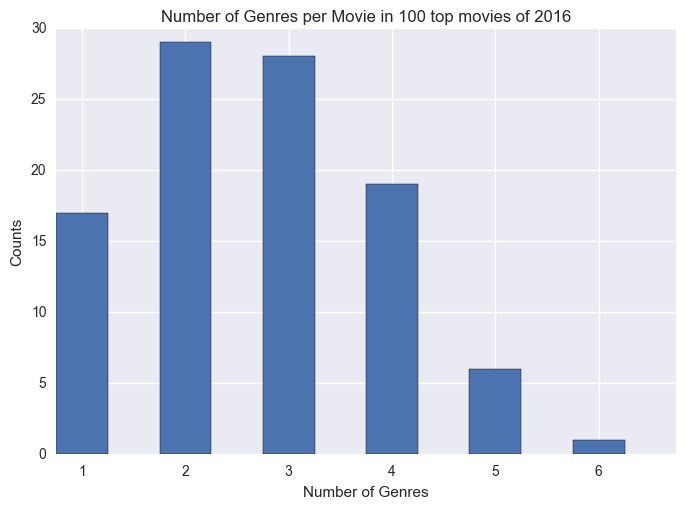

In [78]:
# Create histogram/barplot? of n genres per movie
hist_genre_count = collections.Counter(np.sum(one_hot_encode_genres.values, 1) )
A = hist_genre_count.values()
B = map(int, hist_genre_count.keys())
print A
print B
bar_width = 0.5
fig, ax = plt.subplots()
ax.bar(B, A, bar_width)
ax.set_xticks(np.array(B) + bar_width/2)
ax.set_xticklabels(B)
plt.ylabel("Counts")
plt.xlabel("Number of Genres")
plt.title("Number of Genres per Movie in 100 top movies of 2016")

- On avg, a movie belongs to 2.71 genres

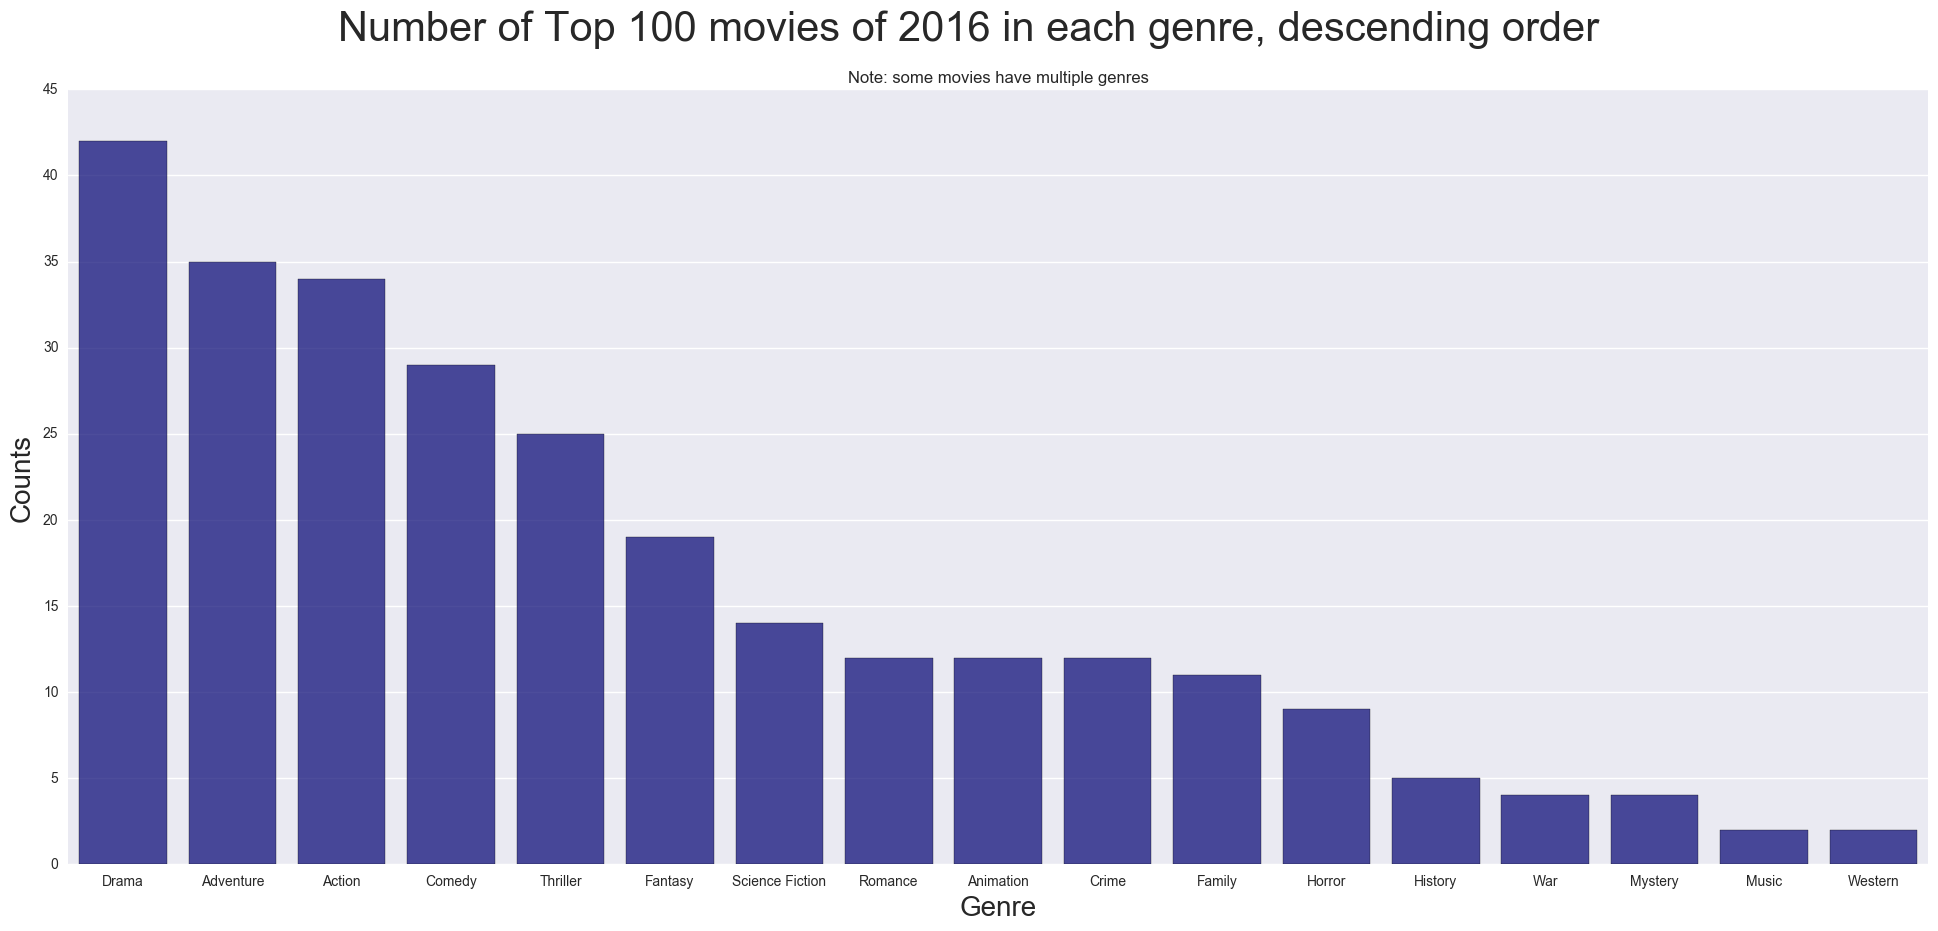

In [95]:
genre_names_encoded = [genre_dict_by_id[one_hot_encode_genres.columns[i]] for i in range(len(one_hot_encode_genres.columns))]
genre_counts_df = pd.DataFrame({'genre' :genre_names_encoded, 'counts': np.sum(one_hot_encode_genres.values, 0)})

genre_counts_df_sorted = genre_counts_df.sort_values('counts', ascending = False)

sns.set_context({"figure.figsize": (24, 10)})
plt.plot()
sns.barplot(x = genre_counts_df_sorted['genre'], 
            y = genre_counts_df_sorted['counts'],
           color = 'darkblue',
           alpha = 0.75)
plt.xlabel('Genre', fontsize = 20)
plt.ylabel('Counts', fontsize = 20)
plt.suptitle('Number of Top 100 movies of 2016 in each genre, descending order', fontsize = 30)
plt.title('Note: some movies have multiple genres')

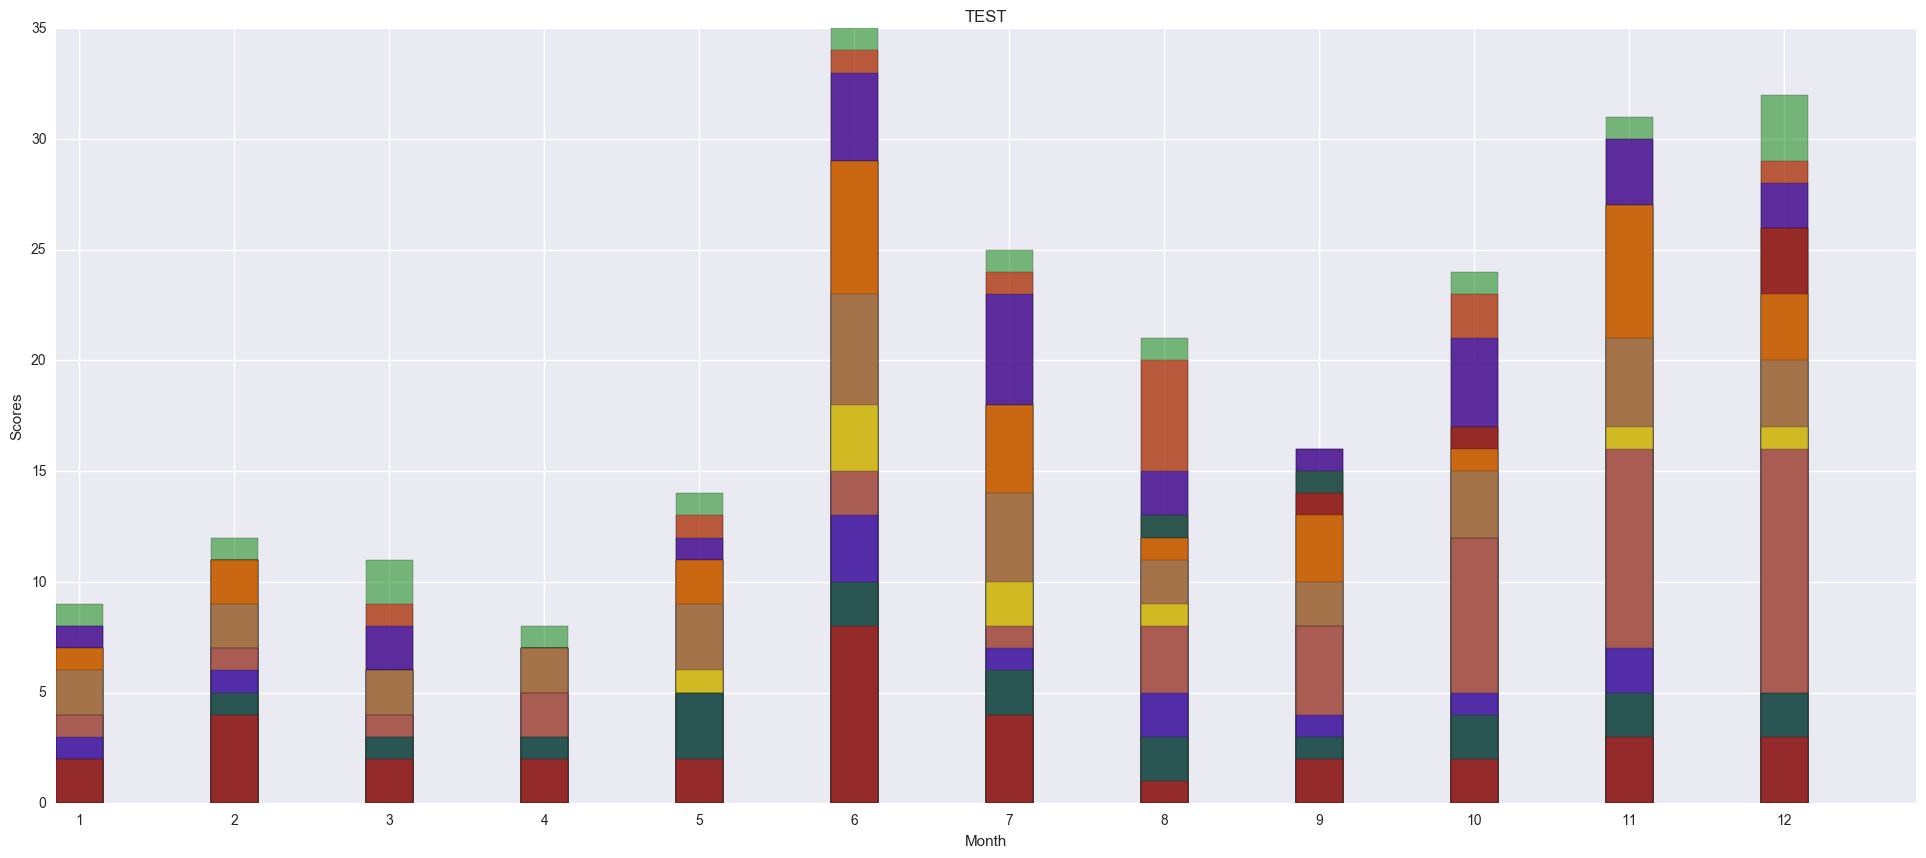

In [25]:
### Get distribution of genres by month
# http://randyzwitch.com/creating-stacked-bar-chart-seaborn/
# First need to count genres by month
sum_genres_by_month = top_100_2016[top_100_2016.columns[-n_unique_genres+1:]].groupby(top_100_2016["release_date"].dt.month).sum()

sum_genres_month_array = np.array(sum_genres_by_month)
cumsum_genres_month_array = np.cumsum(sum_genres_month_array, 1)
#bottom = np.cumsum(ar, axis = 1)
#ind = range(1,5)
#
#plt.bar(ind, ar[0,0], color = 'b')
#for j in xrange(1, ar.shape[1]):
#    plt.bar(ind, ar[j], bottom = bottom[j-1])
#
#
## We have to do dumb things to get a stacked barplot
#f, ax1 = plt.subplots(1, figsize=(10,5))
#bar_width = 0.75


ind = np.arange(12)  # the x locations for the groups
width = 0.3  # the width of the bars

color_list = ['r', 'g', 'b', 'purple', 'yellow', 'grey', 'orange', 'r', 'g', 'b', 'r', 'g', 'b']
fig, ax = plt.subplots()
for i in reversed(range(len(ind))):
    counts_month = cumsum_genres_month_array[:,i]
    rects = ax.bar(ind, counts_month, width, color = color_list[i], alpha = 0.5)


# add some text for labels, title and axes ticks
ax.set_ylabel('Scores')
ax.set_xlabel('Month')
ax.set_title('TEST')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(range(1,13))

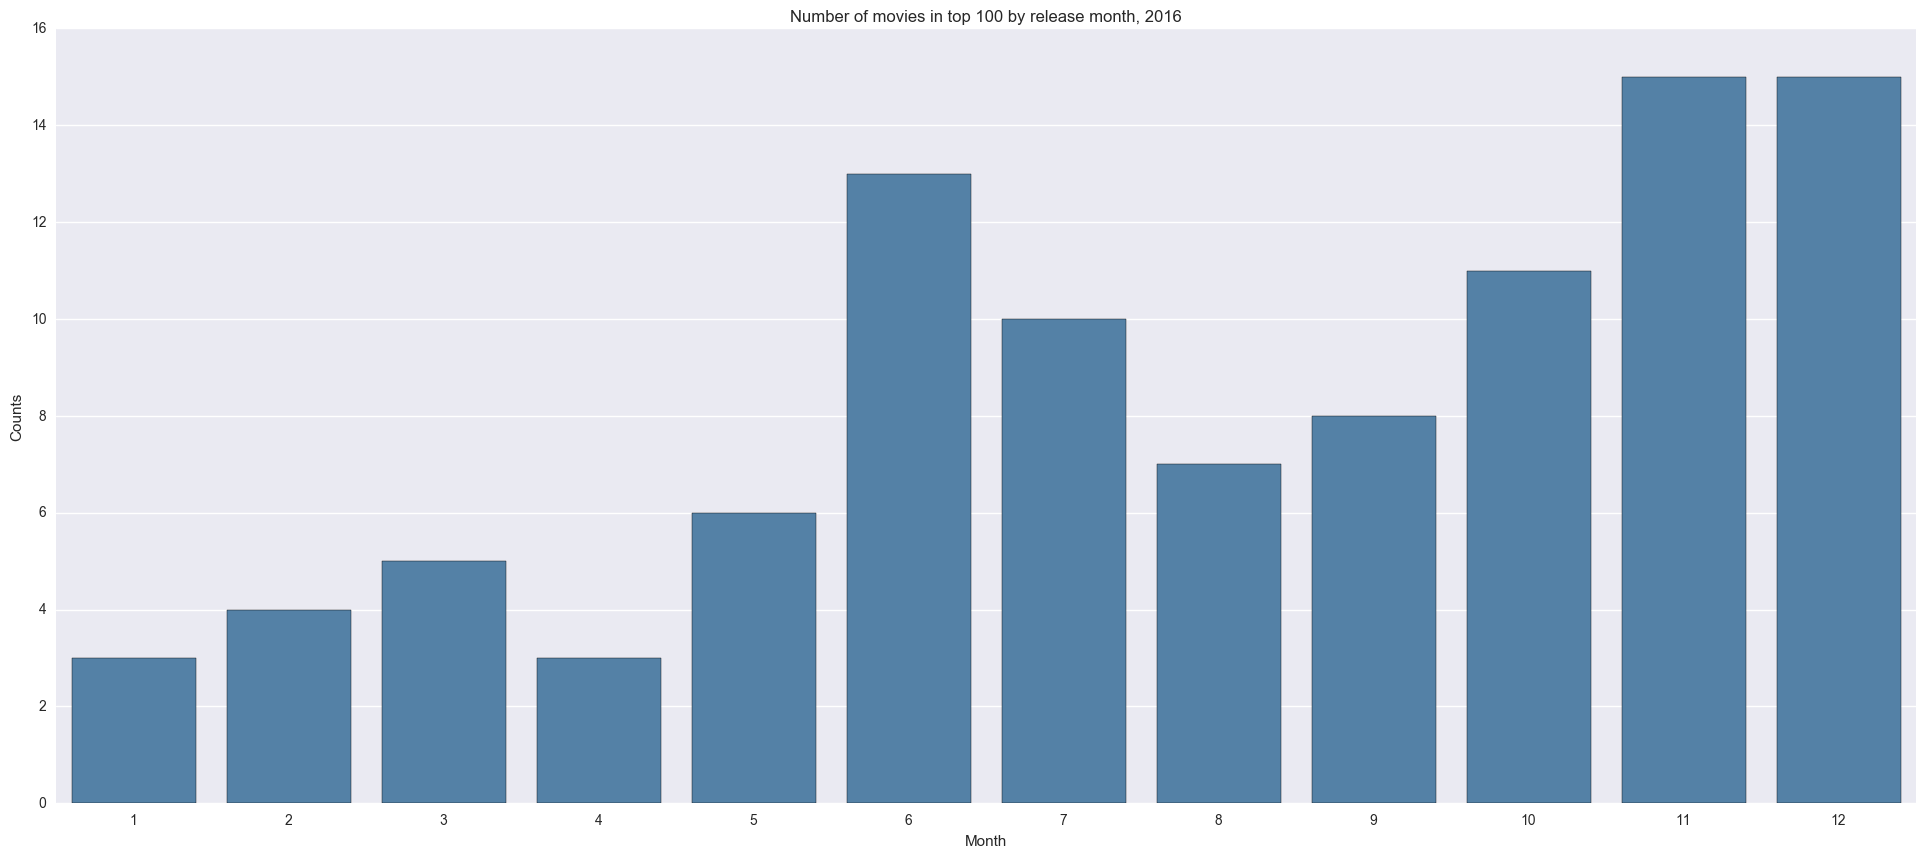

In [96]:
# Plot bar plot of release date (by month)
# http://stackoverflow.com/questions/27365467/python-pandas-plot-histogram-of-dates
counts_by_release_month = top_100_2016['release_date'].groupby(top_100_2016["release_date"].dt.month).count()

plt.figure()
sns.barplot(x = counts_by_release_month.index, 
            y = counts_by_release_month.values, 
            color = 'steelblue')
plt.xlabel('Month')
plt.ylabel('Counts')
plt.title('Number of movies in top 100 by release month, 2016')

# ADD FACET plot of the genre thing

# ADD PROPOSALS!